This notebook trains a UNet topology on the satellite data. It can operate on the different bands of information `A|M|P|RGB` individually, but not together. The training relies on the cross-entropy loss function. It seems training multiple classes simultaneously is ineffective, probably due to class imbalances. For a single class, the validation data appears to be good in the eyeball norm, even if there are some artefacts around the edges.

In [1]:
import os    
# tell this script to use gpu, will want to use cpu for prediction simultane  
os.environ['THEANO_FLAGS'] = "device=gpu0" 
import keras
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend
from keras.backend import binary_crossentropy
backend.set_image_dim_ordering('th')

import numpy as np
import itertools
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (5, 5)

import helper # contains some function that are used by a few of the notebooks on this matter
import jaccard # contains some functions that compute the jaccard metric 

BAND = 'RGB' # which band to use
CLASSES = (0,) # which class(es) to train
class_str = helper.classes_string(CLASSES)

N_BANDS = {'A': 8, 'M': 8, 'P': 1, 'RGB': 3}
INPUT_SIZES = {'A': 128, 'M': 256, 'P': 1024, 'RGB': 1024}
SMOOTH = 1e-10
N_VAL = 10

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/home/icarus/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Set up the network topology

In [4]:
def get_unet(classes):
    N_classes = len(classes)
    isz = INPUT_SIZES[BAND]
    inputs = Input((N_BANDS[BAND], isz, isz))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(N_classes, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(lr=0.000001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = get_unet(CLASSES)
model.save('model.hdf5')

Train the network:

In [5]:
def train_net(model, classes, weights=None, history=None):
    print "start train net"
    input_size = INPUT_SIZES[BAND]

    if weights:
        model.load_weights('weights/{:s}'.format(weights))
    model_checkpoint = ModelCheckpoint('weights/unet_tmp_classes{:s}.hdf5'.format(class_str),
                                       monitor='loss', save_best_only=True)
    
    X_val, y_val, X_trn, y_trn = helper.get_more_patches(BAND, input_size, repetitions=1, classes=classes)
    print X_val.nbytes
    print 'loaded validation and training data sets into memory'

    new_history = model.fit(X_trn, y_trn, batch_size=2, nb_epoch=10, verbose=1, shuffle=True,
              callbacks=[model_checkpoint], validation_data=(X_val, y_val))
    score, trs, y_prd = jaccard.calc_jacc(model, X_val, y_val)
    model.save_weights('weights/unet_band{:s}_score{:.4f}_classes{:s}.hdf5'.format(BAND, score, class_str))
    print '{:.4f} label sum in validation, training and prediction:'.format(score), y_val.sum(axis=(0, 2, 3)), y_trn.sum(axis=(0, 2, 3)), y_prd.sum(axis=(0, 2, 3))

    if history is None:
        history = new_history
    else:
        for key, val in new_history.history.items():
            history.history[key] = history.history[key] + val

    return model, history

In [ ]:
history = None
for superepoch in range(10):
    model, history = train_net(model, CLASSES, history=history, weights='unet_tmp_classes{:s}.hdf5'.format(class_str))

start train net
125829120
loaded validation and training data sets into memory
Train on 20 samples, validate on 5 samples
Epoch 1/10
20/20 [==============================] - 48s - loss: 0.1427 - acc: 0.9665 - val_loss: 0.2442 - val_acc: 0.9377
Epoch 2/10
20/20 [==============================] - 49s - loss: 0.1424 - acc: 0.9665 - val_loss: 0.2435 - val_acc: 0.9377
Epoch 3/10
20/20 [==============================] - 49s - loss: 0.1422 - acc: 0.9665 - val_loss: 0.2433 - val_acc: 0.9377
Epoch 4/10
20/20 [==============================] - 49s - loss: 0.1422 - acc: 0.9665 - val_loss: 0.2429 - val_acc: 0.9377
Epoch 5/10
20/20 [==============================] - 49s - loss: 0.1419 - acc: 0.9665 - val_loss: 0.2421 - val_acc: 0.9377
Epoch 9/10
20/20 [==============================] - 49s - loss: 0.1422 - acc: 0.9665 - val_loss: 0.2415 - val_acc: 0.9377
Epoch 10/10
20/20 [==============================] - 49s - loss: 0.1420 - acc: 0.9665 - val_loss: 0.2413 - val_acc: 0.9377
0 0.7666015625 0.34
0.0

KeyboardInterrupt: 

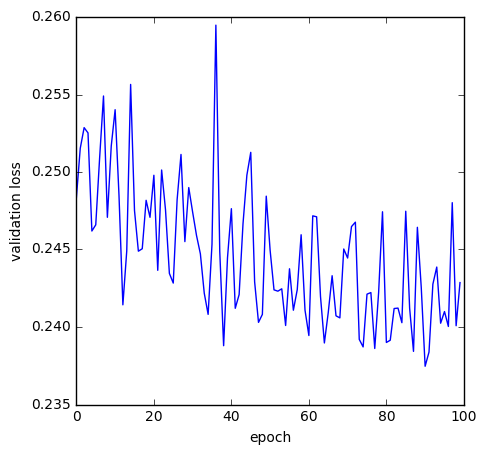

In [52]:
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('validation loss')
# plt.savefig('val_loss.png')

In [36]:
history.history['val_loss']

[0.53363726139068601,
 0.40545186996459959,
 0.42427934408187867,
 0.35679300129413605,
 0.38380743265151979,
 0.47683820128440857,
 0.34749456346035001,
 0.37575367689132688,
 0.37523713111877444,
 0.33853585124015806,
 0.34480912387371065,
 0.4376259446144104,
 0.32996282577514646,
 0.37796559929847717,
 0.33073592483997344,
 0.38067867755889895,
 0.32367329895496366,
 0.39609495401382444,
 0.32546149343252184,
 0.33207647800445556]

[0.67722572088241573,
 0.44977658241987228,
 0.47551475465297699,
 0.4289169028401375,
 0.43678405582904817,
 0.478101110458374,
 0.45295405983924864,
 0.45039038658142089,
 0.41261821091175077,
 0.41114613711833953,
 0.67722572088241573,
 0.44977658241987228,
 0.47551475465297699,
 0.4289169028401375,
 0.43678405582904817,
 0.478101110458374,
 0.45295405983924864,
 0.45039038658142089,
 0.41261821091175077,
 0.41114613711833953]

Draw a pretty representation of the network

In [48]:
import pydot
from keras.utils.visualize_util import plot
plot(model, to_file='scheme.png', show_shapes=True)